
# Introduction
There is a large amount of text based data created at businesses and this data can be highly useful if extracted and modeled correctly. This project will focus on text data, specifically BBC news articles. This is a classification project, each training article is labeled with one of five categories: business, entertainment, politics, sport or tech. We will try to classify the topic of each article based on the words that make up the text of the article. 

Even though there are labels, we will first attempt to build and train an unsupervised learning model using matrix factorization. Then we will compare those results to supervised learning models. The metric used to evaluate the models will be accuracy. 

# The Data
The dataset comes from Kaggle at this link:https://www.kaggle.com/c/learn-ai-bbc/overview.

There are 2,225 articles in the dataset, with 1,490 for training and 735 for testing. 

We will look more into the properties of the data below:

In [1]:
#import all necessary libraries
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
import math

In [2]:
#read in train and testing data to dfs
train_data = pd.read_csv("BBC News Train.csv")
test_data = pd.read_csv("BBC News Test.csv")

#show the info of dataframes and sample of train data
test_data.info()
train_data.info()

train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


<Axes: >

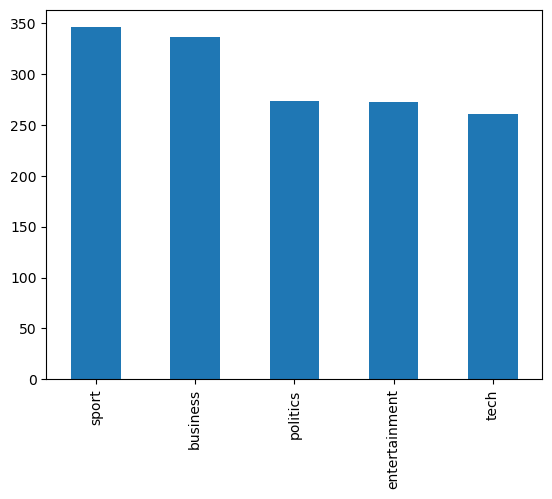

In [3]:
#Put categories into variable
y_train = train_data['Category']

#histogram for Category column
train_data['Category'].value_counts().plot(kind='bar')

The training data has 1490 samples, and 3 columns: ArticleId, Text (the text of the article), and Category. The test data has 735 samples with 2 columns, the ArticleId and Text. There are no null values.

The histogram shows that the data is balanced with similar number of articles per category.

Next we will look at the number of words in each article and break it down by category.

We will also look at the counts of a few different words that seem specific to one of the categories.

In [4]:
#count the number of words in the text of each article
train_data['Word Count'] = train_data.apply(lambda row : len(row['Text'].split()), axis= 1)

#Count the number of characters in text
train_data['Ball Count'] = train_data.apply(lambda row : row['Text'].count('ball'), axis= 1)
train_data['Computer Count'] = train_data.apply(lambda row : row['Text'].count('computer'), axis= 1)
train_data['Growth Count'] = train_data.apply(lambda row : row['Text'].count('growth'), axis= 1)
train_data['Actor Count'] = train_data.apply(lambda row : row['Text'].count('actor'), axis= 1)
train_data

,ArticleId,Text,Category,Word Count,Ball Count,Computer Count,Growth Count,Actor Count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,0,0,0,0
1,154,german business confidence slides german busin...,business,325,0,0,1,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,0,0,1,0
3,1976,lifestyle governs mobile choice faster bett...,tech,634,0,0,0,1
4,917,enron bosses in $168m payout eighteen former e...,business,355,0,0,0,0
...,...,...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,223,0,0,0,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,558,0,0,0,0
1487,1590,weak dollar hits reuters revenues at media gro...,business,237,0,0,2,0
1488,1587,apple ipod family expands market apple has exp...,tech,560,0,0,2,0


<Axes: xlabel='Category', ylabel='Word Count'>

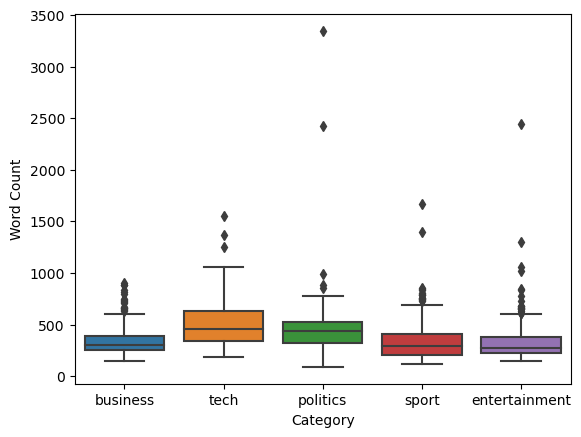

In [5]:
#Create boxplot for word count
sns.boxplot(x = 'Category', y = 'Word Count', data = train_data)

The word counts between categories are similar. Tech articles have the highest word count, but it does not look to be such a significant difference that it would interfere with our analysis and modeling.

<Axes: xlabel='Category', ylabel='Actor Count'>

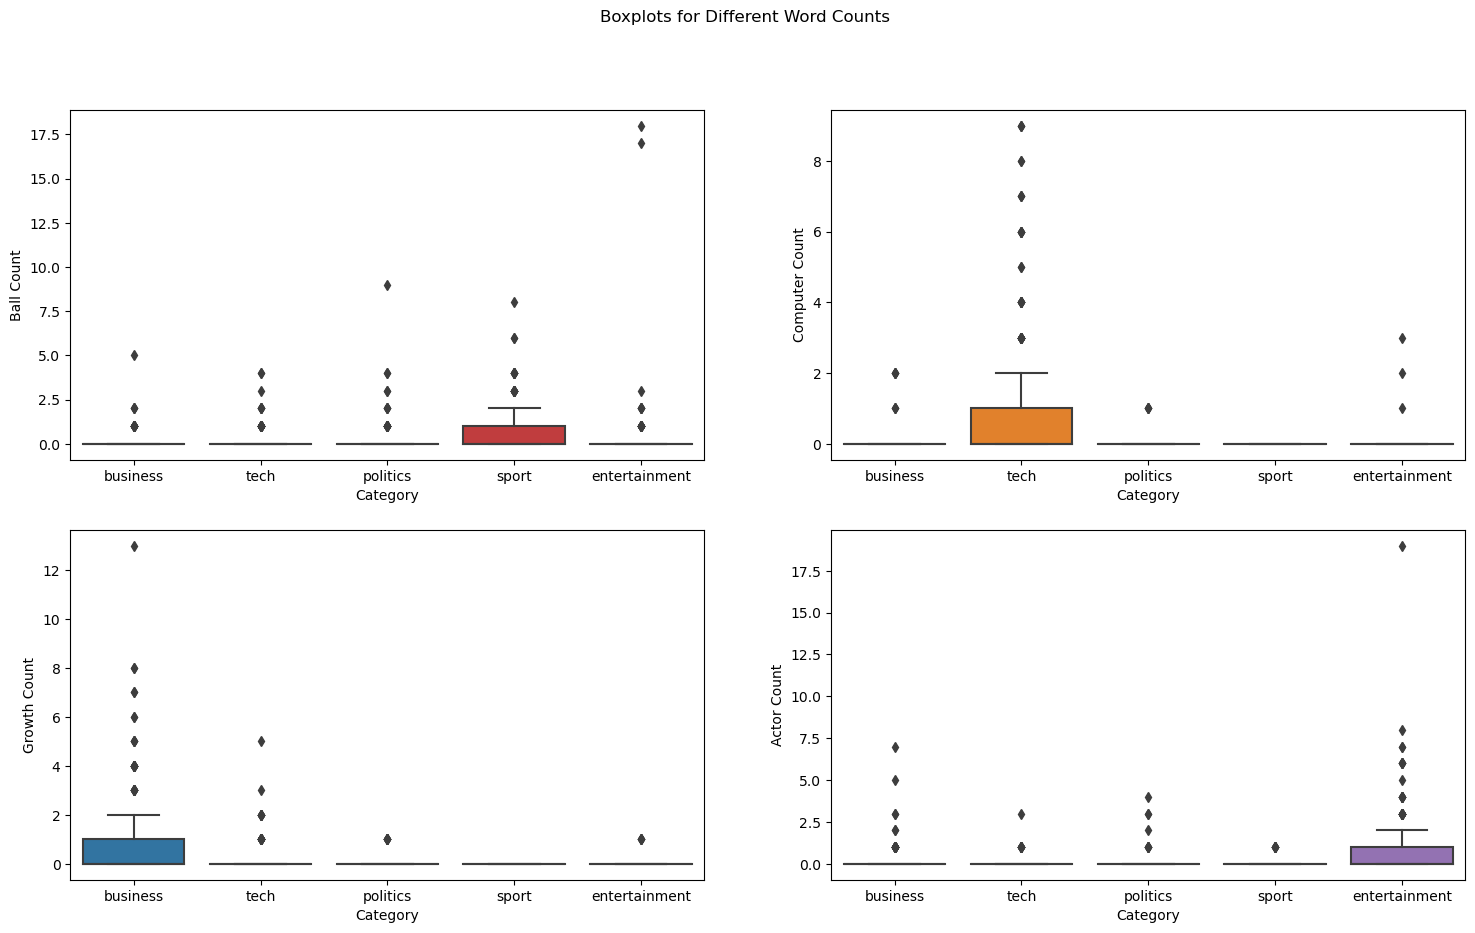

In [6]:
#Create boxplot for different word counts
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Boxplots for Different Word Counts')
 
sns.boxplot(ax=axes[0, 0], x = 'Category', y = 'Ball Count', data = train_data)
sns.boxplot(ax=axes[0, 1], x = 'Category', y = 'Computer Count', data = train_data)

sns.boxplot(ax=axes[1, 0], x = 'Category', y = 'Growth Count', data = train_data)
sns.boxplot(ax=axes[1, 1], x = 'Category', y = 'Actor Count', data = train_data)

The boxplots above show the number of times a specific word appeared in the article. The top left one is counts for the word "ball", top right for "computer", bottom left for "growth", and bottom right for "actor". 

The plots behave as expected, the category most closely associated with the word (such as sport for ball) has the highest counts. However, the other categories do have some outlier articles that do mention the word. This helps illustrate what we will be doing with the models: analyze the words and build a model that can differentiate what category a block of text belongs to based on its words. 

The analysis plan is to transform each article's text to a matrix of word frequencies. Then we will use a non-negative matrix factorization model to transform the matrix of word frequencies to 5 components correlating to the 5 possible categories for the news articles. Then from there, we can predict the category by taking the largest value in each row.  

# Transform text to matrix
We will use TfidfVectorizer to transform our text to a matrix of features (word frequencies).

TfidfVectorizer first performs a countVectorizer and then a TfidfTransformer. The countVectorizer goes through all the content provided and creates a count per row (per article in our case) for each word. The TfidfTransformer then converts this raw count matrix to a term-frequency times inverse document-frequency matrix. This means that it scales down the impact of words that occur very frequently in the input. This is helpful, because some words will appear in almost every article and will not provide much information about the category. This is a very common scaling technique and has been found useful for document classification. 

We are going to create the word features based on the training and test set. Since we have both sets of data, we will use them both because this can lead to additional features in the matrix, which can improve the model. There is no worry about data leak because the labels are not used in the unsupervised model.

In [7]:
#Just need the text column of both test and train to vectorize
all_text = pd.concat([train_data['Text'],test_data['Text']])

#Use TfidfVectorizer to transform article text to matrix of features
#will use default values here, then try different values later to see if can improve
vectorizer1 = TfidfVectorizer()

#fit to the training data text and transform the text to matrix
word_freq1 = vectorizer1.fit_transform(all_text)

#Get the feature names (words) that go to the matrix columns
feature_names1 = vectorizer1.get_feature_names_out()

#split back to train and test set
#first 1490 rows are the train, rest test
train_word_freq1 = word_freq1[:1490,:]
test_word_freq1 = word_freq1[1490:,:]

#print shape of data sets. Should be 1490 rows for train and 735 for test
#and should be same number of columns 
print(train_word_freq1.shape)
print(test_word_freq1.shape)

(1490, 29421)
(735, 29421)


<Axes: >

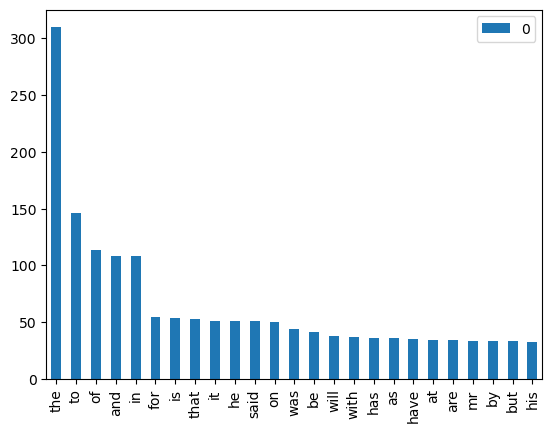

In [8]:
#get total frequencies across all training articles
totals = np.array(train_word_freq1.sum(axis=0))[0]

#create df with feature names and totals to visualize
fn_wf_df = pd.DataFrame(totals, index = feature_names1)

#take top 25 most frequent words and plot
top25 = fn_wf_df.sort_values(by=[0], ascending = False).iloc[:25]
top25.plot(kind='bar')

The plot above shows the 25 most frequent words across all articles in the training set. The 25 most frequent words are all "unimportant" words and don't add much context. 

The first models will use these words, and then another set of models will do some data cleaning to remove all the stop words.

# Models
### Unsupervised Models
We will first build a Non-negative matrix factorization (NMF) and use it to make predictions on our data. We are using NMF because it will allow us to easily transform the matrix of features into a matrix, W, with 5 columns. Each column (or component) will correlate to one of the categories. Then we can make the category prediction of the article by taking the max value of each row. 

The first two code blocks are functions. The label permutation function will find which categories correspond to what colum in the matrix factorization.

In [9]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: true labels dataframe
    yp: predicted labels
    Returns permuted label order that provides highest accuracy. 
    """
    #initialize variables
    i = 0
    high_acc = 0
    high_perm = None
    
    #get unique categories
    categories =  ytdf['Category'].unique().tolist()
    
    #go through all permutations of categories
    for perm in itertools.permutations(categories, len(categories)):
        #change prediction to this permutation of values
        yp_perm = [perm[yp[i]] for i in range(len(yp))]
        
        #check accuracy of the predictions
        accuracy = accuracy_score(ytdf['Category'],yp_perm)

        #if accuracy greater than current high_acc, set as new high_acc and perm
        if accuracy > high_acc:
            high_acc = accuracy
            high_perm = perm
            
    return high_perm, round(high_acc,3)


In [10]:
def make_prediction(W, ytdf):
    """
    W: transformed matrix from NMF model
    ytdf: true labels dataframe
    Returns the predicted values as strings, and the label
    dictionary for tranforming from int to string
    """ 
    #get prediction by getting index of max number in row
    yp = np.argmax(W, axis = 1)

    #find label order for predictions that results in highest accuracy
    labelorder, acc = label_permute_compare(train_data,np.argmax(W, axis = 1))

    #turn labelorder into a dictionary
    label_dict = { indx: val for indx, val in enumerate(list(labelorder))}
    print(label_dict)

    yp = [label_dict[ele] for ele in np.argmax(W, axis = 1)]
    
    return yp, label_dict

In [11]:
#create NMF model and transform
model = NMF(n_components = 5, random_state=0)
W = model.fit_transform(train_word_freq1)
H = model.components_
W

array([[0.0446507 , 0.04513287, 0.00786438, 0.        , 0.0019418 ],
       [0.1498074 , 0.        , 0.        , 0.        , 0.        ],
       [0.1154063 , 0.0199692 , 0.01420934, 0.00945532, 0.03352659],
       ...,
       [0.14408761, 0.        , 0.00288988, 0.        , 0.        ],
       [0.04216527, 0.        , 0.        , 0.01013361, 0.18704225],
       [0.02748754, 0.        , 0.00865977, 0.0020726 , 0.10123945]])

In [12]:
#Make predictions from model
yp_train, label_dict = make_prediction(W, train_data)
acc = accuracy_score(train_data['Category'],yp_train)
print("Train Accuracy: ", acc)


{0: 'business', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'tech'}
Train Accuracy:  0.876510067114094


This first model used all defaults for the Tdidfvectorizer and the NMF. The accuracy was 87.7%, which seems pretty good! We will try to tune both parts of the model to see if we can increase the accuracy.

In [13]:
#transform test data and check accuracy
W_test = model.transform(test_word_freq1)
yp_test = [label_dict[ele] for ele in np.argmax(W_test, axis = 1)]

In [14]:
#set articleId and predictions to df and write to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution1.csv")
#Accuracy from Kaggle: 0.87755

We will discuss the test results in the results section.

### Improve Model
We will now build another Non-negative matrix factorization, but change some of the defaults for the NMF function.

Many hyperparameter values were tried and the chosen ones led to the best results. 

In [15]:
#Build another NMF model and tune parameters to get best accuracy
model = NMF(n_components = 5, random_state=0, beta_loss = 'kullback-leibler', solver = 'mu')
W = model.fit_transform(train_word_freq1)

#Make predictions from model
yp_train, label_dict = make_prediction(W, train_data)
acc = accuracy_score(train_data['Category'],yp_train)
print("Train Accuracy: ", acc)


{0: 'business', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'tech'}
Train Accuracy:  0.9181208053691275


In [16]:
#transform test data and check accuracy
W_test = model.transform(test_word_freq1)
yp_test = [label_dict[ele] for ele in np.argmax(W_test, axis = 1)]

#set articleId and predictions to df and write to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution1b.csv")
#Accuracy from Kaggle: 0.94829

These changes to NMF improved the accuracy from 87.7% to 91.8%! We will try to make changes to the Tfidfvectorizer to see if we can further improvement the model.

## Try different word features - Data Cleaning

The following tranformation from article text to feature matrix will do some data cleaning by removing stop words. All stop word options in TfidfVectorizer were trialed and the option for "english" gave the best results. The english stop word removal cleans the data by removing words that are typically uninformative, such as "and", "the", "him", among many others. 

In [17]:
#Use TfidfVectorizer to transform article text to matrix of features (term frequencies)
#will change the default values to try to improve models
vectorizer2 = TfidfVectorizer(min_df=5, stop_words = 'english',ngram_range=(1, 2),sublinear_tf=True)

word_freq2 = vectorizer2.fit_transform(all_text)

feature_names2 = vectorizer2.get_feature_names_out()

#split back to train and test set
#first 1490 rows are the train, rest test
train_word_freq2 = word_freq2[:1490,:]
test_word_freq2 = word_freq2[1490:,:]

print(train_word_freq2.shape)
print(test_word_freq2.shape)

(1490, 14415)
(735, 14415)


In [18]:
#get total frequencies across all train articles
totals2 = np.array(train_word_freq2.sum(axis=0))[0]
#totals

<Axes: >

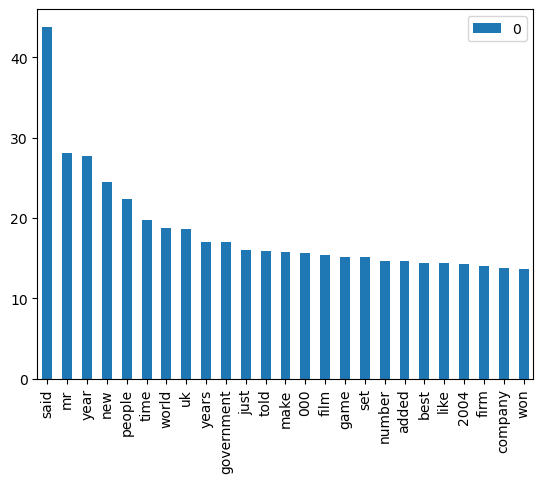

In [19]:
#create df with feature names and totals
#fn_wf_df = pd.DataFrame([feature_names, totals]).T
fn_wf_df = pd.DataFrame(totals2, index = feature_names2)

#take top 25 most frequent words and plot
top25 = fn_wf_df.sort_values(by=[0], ascending = False).iloc[:25]
top25.plot(kind='bar')

The only words that are still in the top 25 of this new feature matrix (that were in the top 25 of the original feature matrix) are "said" and "mr". The words in the chart above have much more meaning in relation to our categories than the original word matrix did. This should lead to improved results in our models. 

In [20]:
#create model and transform
model = NMF(n_components = 5, random_state=0)
W = model.fit_transform(train_word_freq2)

#Make predictions from model
yp_train, label_dict = make_prediction(W, train_data)
acc = accuracy_score(train_data['Category'],yp_train)
print("Train Accuracy: ", acc)


{0: 'tech', 1: 'sport', 2: 'politics', 3: 'entertainment', 4: 'business'}
Train Accuracy:  0.946979865771812


In [21]:
#predict test data
W_test = model.transform(test_word_freq2)
yp_test = np.argmax(W_test, axis = 1)
yp_test = [label_dict[ele] for ele in yp_test]

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution2a.csv")
solutiondf
#Accuracy from Kaggle: 0.96054

,Category
ArticleId,
1018,sport
1319,tech
1138,sport
459,business
1020,sport
...,...
1923,business
373,entertainment
1704,tech


In [22]:
#create model and transform
model = NMF(n_components = 5, random_state=0, beta_loss = 'kullback-leibler', solver = 'mu')
W = model.fit_transform(train_word_freq2)

#Make predictions from model
yp_train, label_dict = make_prediction(W, train_data)
acc = accuracy_score(train_data['Category'],yp_train)
print("Train Accuracy: ", acc)


{0: 'tech', 1: 'sport', 2: 'politics', 3: 'entertainment', 4: 'business'}
Train Accuracy:  0.9718120805369127


In [23]:
#predict test data
W_test = model.transform(test_word_freq2)
yp_test = np.argmax(W_test, axis = 1)
yp_test = [label_dict[ele] for ele in yp_test]

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution2b.csv")
solutiondf
#Accuracy from Kaggle: 0.9687

,Category
ArticleId,
1018,sport
1319,tech
1138,sport
459,business
1020,sport
...,...
1923,business
373,entertainment
1704,politics


We started with an accuracy of 87.7% and increased it to 97.2% by adjusting parameters in the vectorizer and the NMF! These look to be great results in the training data. We will look further at the test results in the results section.

# Supervised learning models
We will now build and train a few supervised learning models to see how they compare to the matrix factorization models.

In [24]:
#make logisitc regression classifier
lrclf = LogisticRegression()

#fit logistic regression classifier and check accuracy of train data
lrclf.fit(train_word_freq2, y_train)
print("Logisitic Regression Train Accuracy: ",lrclf.score(train_word_freq2,y_train))

#predict test data
yp_test = lrclf.predict(test_word_freq2)

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution3.csv")
#solutiondf
#Test accuracy from Kaggle: .98095

Logisitic Regression Train Accuracy:  0.9973154362416108


In [25]:
#make random forest classifier
#Do cross-validation on various paramter values
rfclf = RandomForestClassifier(max_features = 'sqrt', max_depth = 32, min_samples_leaf = 3, random_state=0)

#fit random forest classifier and check accuracy of train data
rfclf.fit(train_word_freq2, y_train)
print("Random Forest Train Accuracy: ", rfclf.score(train_word_freq2, y_train))

#predict test data
yp_test = rfclf.predict(test_word_freq2)

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution4.csv")
#Test accuracy from Kaggle: .96462

Random Forest Train Accuracy:  0.991275167785235


In [26]:
#make gradient boosting classifier
#Do cross-validation on various paramter values
gbclf = GradientBoostingClassifier(max_features = 'sqrt', max_depth = 4,min_samples_leaf = 8, learning_rate =.1)

#fit gradient boosting classifier and check accuracy of train data
gbclf.fit(train_word_freq2, y_train)
print("Gradient Boosting Train Accuracy: ", gbclf.score(train_word_freq2, y_train))

#predict test data
yp_test = gbclf.predict(test_word_freq2)

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution5.csv")
#Test accuracy from Kaggle: .97278

Gradient Boosting Train Accuracy:  0.9993288590604027


In [27]:
#Make SVM classifier model
#Do cross-validation on various kernel, C, and gamma paramter values
svm = SVC(kernel = 'rbf',C=0.75,gamma = .75)

#fit SVM classifier and check accuracy of train data
svm.fit(train_word_freq2, y_train)
print("Support Vector Classifier Train Accuracy: ", svm.score(train_word_freq2, y_train))

#predict test data
yp_test = svm.predict(test_word_freq2)

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution6.csv")
#Test accuracy from Kaggle: .98231

Support Vector Classifier Train Accuracy:  1.0


# Using only 25% of labeled training data
Now we will compare unsupervised and supervised learning models with 25% of the original data labels. The purpose of this is to see how a smaller set of labeled data affects the outcome of the models.

The unsupervised model can still learn from all the training data (since it doesn't need labels), but then has to figure out what the model's predicted labels mean with only 25% of the original labels. That shouldn't be an issue. In this scenario, the model's predicted labels are 0 through 4 and the original labels are the categories:  business, entertainment, politics, sport or tech.

The supervised learning will only be able to use the 25% of data that has labels since they require the labels to train the model. 

In [28]:
#The data is already randomized, so we will take the first 25% of the dataset
n = math.floor(train_data.shape[0]*.25)
n
train_data25 = train_data.iloc[:n,:]
train_data25

,ArticleId,Text,Category,Word Count,Ball Count,Computer Count,Growth Count,Actor Count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,0,0,0,0
1,154,german business confidence slides german busin...,business,325,0,0,1,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,0,0,1,0
3,1976,lifestyle governs mobile choice faster bett...,tech,634,0,0,0,1
4,917,enron bosses in $168m payout eighteen former e...,business,355,0,0,0,0
...,...,...,...,...,...,...,...,...
367,151,greek sprinters suspended by iaaf greek sprint...,sport,261,0,0,0,0
368,295,china net cafe culture crackdown chinese autho...,tech,388,0,2,0,0
369,1147,bbc leads interactive bafta wins the bbc and t...,tech,341,0,0,0,0
370,754,italy aim to rattle england italy coach john k...,sport,389,0,0,0,1


In [29]:
#create model and transform
#Can still use same train freq because it is testing without labels
#the train_word_freq2 does not depend on labels
model = NMF(n_components = 5, random_state=0, beta_loss = 'kullback-leibler', solver = 'mu')
W = model.fit_transform(train_word_freq2)

#Make predictions from model
yp_train, label_dict = make_prediction(W, train_data25)
acc = accuracy_score(train_data['Category'],yp_train)
print("Train Accuracy: ", acc)

{0: 'tech', 1: 'sport', 2: 'politics', 3: 'entertainment', 4: 'business'}
Train Accuracy:  0.9718120805369127


In [30]:
W_test = model.transform(test_word_freq2)
yp_test = np.argmax(W_test, axis = 1)
yp_test = [label_dict[ele] for ele in yp_test]

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution7.csv")
#solutiondf
#Accuracy from Kaggle: 0.9687

Now will try supervised learning models with 25% of labeled data

In [31]:
#Get the 25% y_train data for labels and the first 25% of the word freq (X)
#to train the supervised models
y_train25 = y_train.iloc[:n]
#y_train25
train_word_freq25 = train_word_freq2[:n]
train_word_freq25

<372x14415 sparse matrix of type '<class 'numpy.float64'>'
	with 55373 stored elements in Compressed Sparse Row format>

In [32]:
#make logisitc regression classifier
lrclf = LogisticRegression()

#fit ligistic regression classifier and check accuracy of train data
lrclf.fit(train_word_freq25, y_train25)
print("Logisitic Regression Train Accuracy: ",lrclf.score(train_word_freq25,y_train25))

#check accuracy of test data
yp_test = lrclf.predict(test_word_freq2)

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution8.csv")
#solutiondf
#Test accuracy from Kaggle: .94829

Logisitic Regression Train Accuracy:  1.0


In [33]:
#Make SVM classifier model
#Do cross-validation on various kernel, C, and gamma paramter values
svm = SVC(kernel = 'rbf',C=0.75,gamma = .75)

svm.fit(train_word_freq25, y_train25)
print("Support Vector Classifier Train Accuracy: ", svm.score(train_word_freq25, y_train25))

#check accuracy of test data
yp_test = svm.predict(test_word_freq2)

#Write results to csv to submit to Kaggle
solutiondf = pd.DataFrame(yp_test, columns = ['Category'], index = test_data['ArticleId'])
solutiondf.to_csv("solution9.csv")
#Test accuracy from Kaggle: .8721

Support Vector Classifier Train Accuracy:  1.0


# Results
|Model Type|Vectorizer Tuned?|NMF Tuned?| 25% of Labeled Data | Train Accuracy| Test Accuracy|
|:----|:--------:|:--------:|:--------:|:--------:|:--------:|
|Non-negative matrix factorization| N | N | N | 0.877 | 0.878 |
|Non-negative matrix factorization| N | Y | N | 0.918 | 0.948 |
|Non-negative matrix factorization| Y | N | N | 0.947 | 0.961 |
|Non-negative matrix factorization| Y | Y | N | 0.972 | 0.969 |
|Logistic Regression| Y | N/A | N | 0.997 | 0.981 |
|Random Forest| Y | N/A | N | 0.991 | 0.965 |
|Gradient Boosting| Y | N/A | N | 0.999 | 0.973 |
|Supprt Vector Calssifier| Y | N/A | N | 1.0 | 0.982 |
|Non-negative matrix factorization| Y | Y | Y | 0.972 | 0.969 |
|Logistic Regression| Y | N/A | Y | 1.0 | 0.948 |
|Supprt Vector Calssifier| Y | N/A | Y | 1.0 | 0.872 |

The test accuracies for all models were greater than 87%, showing that all models did a good job at classifying the news articles. For the non-negative matrix factorization, tuning the vectorizer and nmf function parameters made a significant impact as the test accuracy was increased from 87.8% to 96.9%! This shows how critical it is to tune parameters for all models you train.

The supervised learning models performed better than the best non-negative matrix factorization (with exception of the random forest test accuracy which performed very slightly worse). This should have been expected. The supervised learning models had the labels and were training their models to correctly predict the training labels. The unsupervised learning models did not use the labels and were just trying to differentiate the word frequencies into 5 different components. If you have labels for training data, it makes logical sense to use them. The labels only provide additional information to the models. However, it is somewhat surprising to see just how well the unsupervised models performed. This shows that in situations where you do not have labels, there are still ways to extract insights from the data. 

Using only 25% of the labeled data had very little impact on the unsupervised model (matrix factorization). This was expected since the unsupervised model does not use labels until the end. The only reason it uses the labels is to determine what numerical outcome corresponds to which category. It does not need much data to do this, and is very data-efficient in regards to the labels. Using only 25% of the labeled data for the supervised models had a larger negative impact on their test accuracies. They both had 1.0 train accuracies and worse test accuracies showing that they are most likely overfitting the data now. The test accuracies are still high, just not as good as the models that used 100% of the labeled data. If even less labeled data was used (or available) these models would continue to do worse. This is because they rely on the labels to train their models. The less labels there are, the less data there is to train on, and less data can lead to overfitting. 

# References
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification